#Proyecto de Matemáticas de Machine Learning
#**Tema:** Autoencoder (AE) y Variational Autoencoder (VAE)
#**Profesor**: Francisco Gómez

#**Estudiantes**:
#Oscar Eduardo Reyes Nieto
#Daniel Aragón Urrego
#Sarah Daniella Coral Zuñiga

##Importar librerías

In [1]:
# Importar librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import tensorflow as tf
import time
from collections import defaultdict
from tensorflow.keras.layers import Dense, Input, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K, regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2

##Información: Los datos se encuentran en los archivos adjuntos que acompañan a este cuaderno de Colab, a saber:

Archivo: **"index.xlsx"** Contiene los precios de cierre ajustado del índice Nasdaq 100

Archivo: **"precios.xlsx"** Contiene los precios de cierre ajustado de los constituyentes (acciones) del índice Nasdaq 100

In [2]:
# Cargar datos de las acciones y del índice
stock_prices = pd.read_excel('precios.xlsx', index_col=0, parse_dates=True)
index_prices = pd.read_excel('index.xlsx', index_col=0, parse_dates=True)

# Calculo de los retornos acumulados
stock_returns = np.log(stock_prices / stock_prices.shift()).dropna()
index_returns = np.log(index_prices / index_prices.shift()).dropna()

# Declaración de los periodos de entrenamiento y prueba
train_start = '2019-01-01'
train_end = '2022-12-31'
test_start = '2023-01-01'
test_end = '2023-12-31'

stock_train = stock_returns[train_start:train_end].dropna(axis=1, how='any').astype('float32')
stock_test = stock_returns[test_start:test_end].dropna(axis=1, how='any').astype('float32')

index_train = index_returns[train_start:train_end].astype('float32')
index_test = index_returns[test_start:test_end].astype('float32')

##**Experimento 1**:

**AE Arquitecture**

*Encoder*

+   Input Layer: 86 neurons (number of available assets).
+   First Hidden Layer: 43 neurons, ReLU activation.
+   Output Layer: 43 neurons (latent space dimension).

*Decoder*

+   Input Layer: 43 neurons (latent space dimension).
+   First Hidden Layer: 43 neurons, ReLU activation.
+   Output Layer: 86 neurons, ReLU activation.

*Training Parameters

+   Optimizer: Adam
+   Learning Rate: 0.001 (default in Keras)
+   Loss Function: MSE (Mean Squared Error)
+   Epochs: 100
+   Batch Size: 10

**VAE Arquitecture**

*Encoder*

+   Input Layer: 86 neurons (number of available assets)
+   First Hidden Layer: 43 neurons, ReLU activation
+   Output Layer: z\_mean and z\_log\_var, each with 1 neuron (latent space dimension).

*Sampling Layer*

+   Lambda function for reparameterization to obtain $z$ from z\_mean and z\_log\_var

*Decoder*

+   Input Layer: 2 neurons (latent space dimension)
+   First Hidden Layer: 43 neurons, ReLU activation
+   Output Layer: 86 neurons, ReLU activation

*Training Parameters*

+   Optimizer: Adam
+   Learning Rate: Default (0.001 in Keras)
+   Loss Function: MSE for reconstruction loss + KL Divergence loss
+   Epochs: 100
+   Batch Size: 10

In [3]:
# Funciones auxiliares

#Función para calcular el rendimiento acumulado
def cumulative_returns(returns):
    return (1 + returns).cumprod()

# Función para calcular el tracking error
def tracking_error(actual_returns, predicted_returns):
    return np.sqrt(np.mean((actual_returns - predicted_returns) ** 2))

# Función para seleccionar activos basándose en la reconstrucción del autoencoder y el error cuadrático
def select_top_n_stocks_by_reconstruction_error(stock_data, reconstructed_data, n):
    reconstruction_errors = np.linalg.norm(stock_data - reconstructed_data, axis=0)
    selected_indices = np.argsort(reconstruction_errors)[:n]
    return selected_indices

In [5]:
# Parámetros
encoding_dim = 43
latent_dim = 2
num_stock = 43  # Número de acciones seleccionadas
validation_months = range(1, 13)

# Almacenar los rendimientos acumulados y tracking errors de AE y VAE
ae_cumulative_returns = []
ae_tracking_errors = []
vae_cumulative_returns = []
vae_tracking_errors = []

# Almacenar las pérdidas de entrenamiento y validación para AE y VAE
ae_train_loss = []
ae_val_loss = []
vae_train_loss = []
vae_val_loss = []

# Almacenar los activos seleccionados y sus participaciones para la primera ventana de validación
ae_selected_stocks_first_window = None
ae_stock_weights_first_window = None
vae_selected_stocks_first_window = None
vae_stock_weights_first_window = None

#Se establecerá la cantidad de tiempo de ejecución
inicio = time.time()

# Iterar sobre cada mes móvil en el año 2023
for month in validation_months:
    # Definir el rango de fechas para el mes actual
    valid_month_start = f'2023-{month:02d}-01'
    valid_month_end = pd.date_range(valid_month_start, periods=1, freq='M')[0] + pd.offsets.MonthEnd(0)
    valid_month_end = valid_month_end.strftime('%Y-%m-%d')

    # Definir el rango de fechas para el período de entrenamiento
    train_end = pd.to_datetime(valid_month_start) - pd.Timedelta(days=1)
    train_start = train_end - pd.DateOffset(years=3)

    stock_train = stock_returns.loc[train_start:train_end].dropna(axis=1, how='any').astype('float32')
    stock_test = stock_returns.loc[valid_month_start:valid_month_end].dropna(axis=1, how='any').astype('float32')

    index_train = index_returns.loc[train_start:train_end].astype('float32')
    index_test = index_returns.loc[valid_month_start:valid_month_end].astype('float32')

    num_stocks_available = stock_train.shape[1]

    # Autoencoder
    input_img = Input(shape=(num_stocks_available,))
    encoded = Dense(43, activation='relu')(input_img)
    decoded = Dense(num_stocks_available, activation='relu')(encoded)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Entrenamiento del autoencoder
    ae_history = autoencoder.fit(stock_train, stock_train, validation_data=(stock_test, stock_test),
                                 shuffle=False, epochs=100, batch_size=10, verbose=0)

    ae_train_loss.append(ae_history.history['loss'])
    ae_val_loss.append(ae_history.history['val_loss'])

    # Selección de activos para AE
    ae_reconstruct = autoencoder.predict(stock_train)
    ae_selected_indices = select_top_n_stocks_by_reconstruction_error(stock_train.values, ae_reconstruct, num_stock)
    ae_selected_stocks = stock_train.columns[ae_selected_indices]

    if ae_selected_stocks_first_window is None:
        ae_selected_stocks_first_window = ae_selected_stocks
        # Calcular las participaciones porcentuales
        ae_stock_weights_first_window = np.mean(stock_train[ae_selected_stocks], axis=0) / np.mean(stock_train[ae_selected_stocks], axis=0).sum()

    # Rendimientos acumulados y tracking error para AE
    ae_reconstruct_test = autoencoder.predict(stock_test)
    ae_predicted_returns = np.dot(stock_test[ae_selected_stocks], ae_stock_weights_first_window)
    ae_cumulative_returns.append(np.cumprod(1 + ae_predicted_returns) - 1)
    ae_tracking_errors.append(tracking_error(index_test.values.flatten(), ae_predicted_returns))

    # Variational Autoencoder
    def sampling(args):
      z_mean, z_log_var = args
      batch = K.shape(z_mean)[0]
      dim = K.int_shape(z_mean)[1]
      epsilon = K.random_normal(shape=(batch, dim))
      return z_mean + K.exp(0.5 * z_log_var) * epsilon

    def build_encoder(input_shape, latent_dim):
      inputs = Input(shape=input_shape)
      x = Dense(43, activation='relu')(inputs)
      z_mean = Dense(latent_dim)(x)
      z_log_var = Dense(latent_dim)(x)
      z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
      return Model(inputs, [z_mean, z_log_var, z])

    def build_decoder(latent_dim, original_dim):
      latent_inputs = Input(shape=(latent_dim,))
      x = Dense(43, activation='relu')(latent_inputs)
      outputs = Dense(original_dim, activation='relu')(x)
      return Model(latent_inputs, outputs)

    def build_vae(input_shape, latent_dim):
      encoder = build_encoder(input_shape, latent_dim)
      decoder = build_decoder(latent_dim, input_shape[0])
      inputs = Input(shape=input_shape)
      z_mean, z_log_var, z = encoder(inputs)
      outputs = decoder(z)

      vae = Model(inputs, outputs)

      reconstruction_loss = K.sum(K.square(inputs - outputs), axis=-1)
      kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
      vae_loss = K.mean(reconstruction_loss + kl_loss)
      vae.add_loss(vae_loss)

      vae.compile(optimizer=Adam(learning_rate=0.001))
      return vae, encoder

    # Construir y entrenar el VAE
    latent_dim = 2
    vae, encoder = build_vae((num_stocks_available,), latent_dim)
    vae_history = vae.fit(stock_train, epochs=100, batch_size=10, validation_data=(stock_test, None), shuffle=False, verbose=0)

    vae_train_loss.append(vae_history.history['loss'])
    vae_val_loss.append(vae_history.history['val_loss'])

    # Selección de activos para VAE
    vae_reconstruct = vae.predict(stock_train)
    vae_selected_indices = select_top_n_stocks_by_reconstruction_error(stock_train.values, vae_reconstruct, num_stock)
    vae_selected_stocks = stock_train.columns[vae_selected_indices]

    if vae_selected_stocks_first_window is None:
        vae_selected_stocks_first_window = vae_selected_stocks
        # Calcular las participaciones porcentuales
        vae_stock_weights_first_window = np.mean(stock_train[vae_selected_stocks], axis=0) / np.mean(stock_train[vae_selected_stocks], axis=0).sum()

    # Rendimientos acumulados y tracking error para VAE
    vae_reconstruct_test = vae.predict(stock_test)
    vae_predicted_returns = np.dot(stock_test[vae_selected_stocks], vae_stock_weights_first_window)
    vae_cumulative_returns.append(np.cumprod(1 + vae_predicted_returns) - 1)
    vae_tracking_errors.append(tracking_error(index_test.values.flatten(), vae_predicted_returns))

1/1 [==============================] - 0s 17ms/step


In [6]:
fin = time.time()
print('Tiempo (segundos) de ejecución de los modelos:',fin-inicio)

396.0617997646332


##Visualizaciones de los resultados

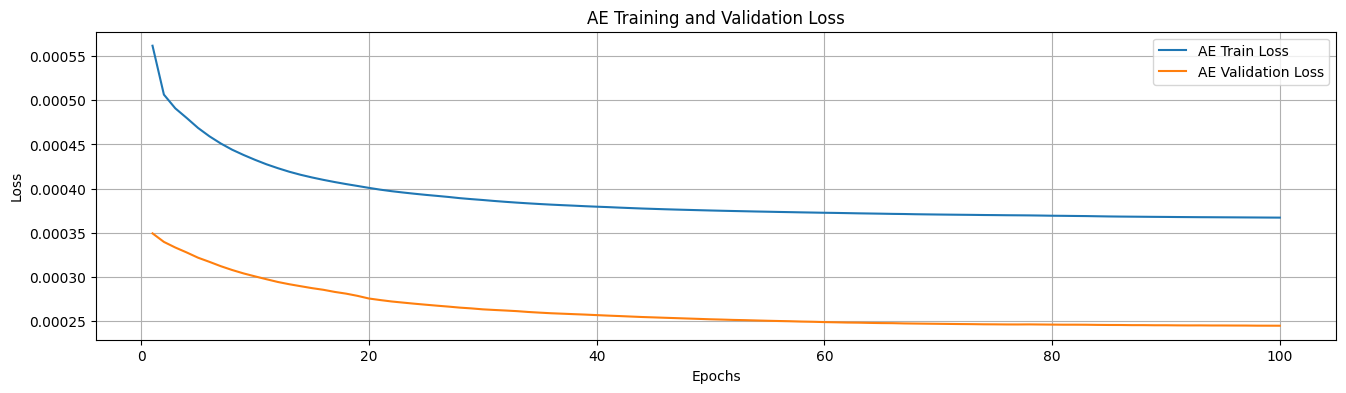

In [7]:
# Graficar las pérdidas de entrenamiento y validación para AE y VAE
epochs = range(1, 101)
plt.figure(figsize=(16, 4))
plt.plot(epochs, np.mean(ae_train_loss, axis=0), label='AE Train Loss')
plt.plot(epochs, np.mean(ae_val_loss, axis=0), label='AE Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('AE Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('E1: AE Training and Validation Loss.png')
plt.show()

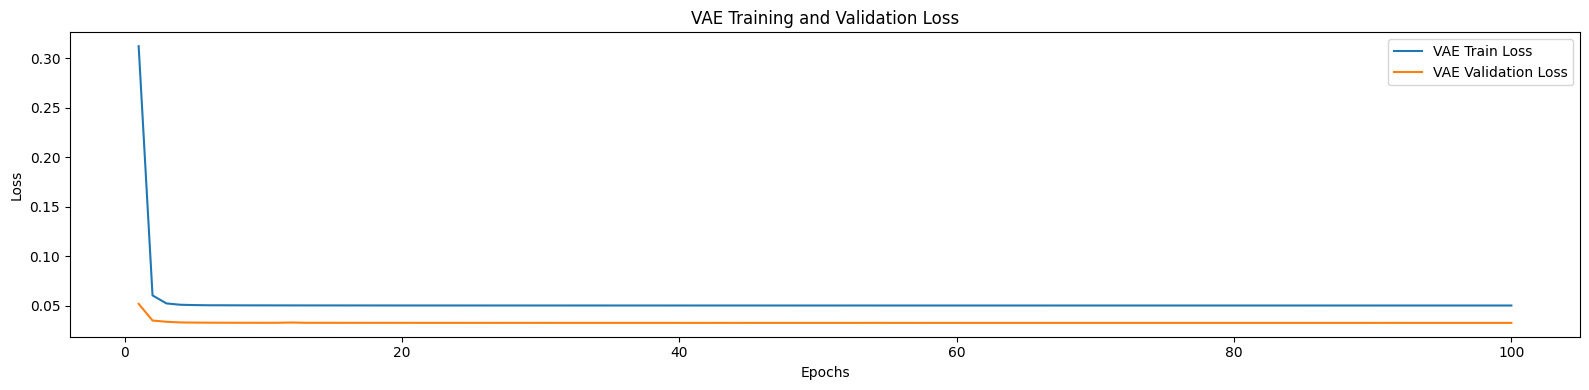

In [8]:
#Grafica de Loss para AE y VAE
plt.figure(figsize=(16,4))
plt.plot(epochs, np.mean(vae_train_loss, axis=0), label='VAE Train Loss')
plt.plot(epochs, np.mean(vae_val_loss, axis=0), label='VAE Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VAE Training and Validation Loss')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig('E1: VAE Training and Validation Loss.png')
plt.show()

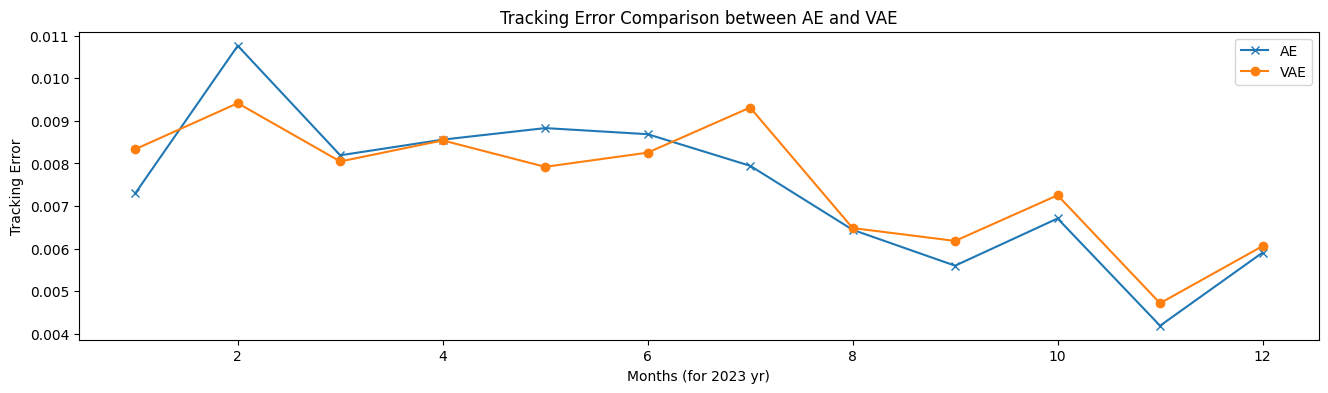

In [9]:
# Grafica de los rendimientos acumulados y tracking errors para AE y VAE
plt.figure(figsize=(16,4))
plt.plot(validation_months, ae_tracking_errors, label='AE', marker='x')
plt.plot(validation_months, vae_tracking_errors, label='VAE', marker='o')
plt.xlabel('Months (for 2023 yr)')
plt.ylabel('Tracking Error')
plt.title('Tracking Error Comparison between AE and VAE')
plt.legend()
plt.grid(False)
plt.savefig('E1: Tracking Error Comparison between AE and VAE.png')
plt.show()

Tracking Error mean_AE: 0.0074258763
Tracking Error mean_VAE: 0.007542465


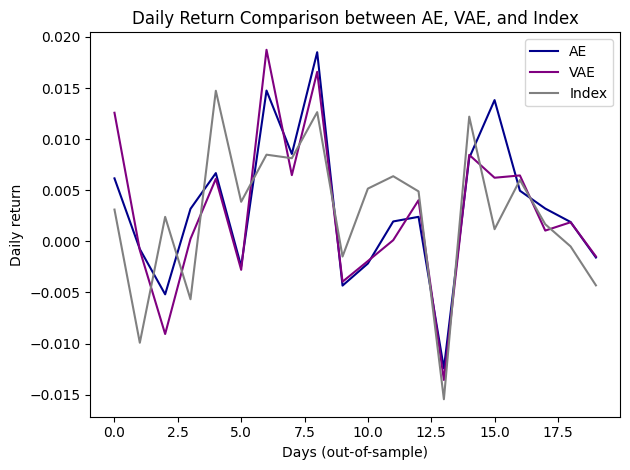

In [10]:
# Promedio de Tracking Error por modelo
AE_mean_TE = np.mean(ae_tracking_errors)
VAE_mean_TE = np.mean(vae_tracking_errors)
print('Tracking Error mean_AE:', AE_mean_TE)
print('Tracking Error mean_VAE:', VAE_mean_TE)

# Grafica de comparación de retorno diario entre el índice y los portafolios AE y VAE
plt.plot(figsize=(16,4))
plt.plot(ae_predicted_returns, label='AE', color='darkblue')
plt.plot(vae_predicted_returns, label='VAE', color='purple')
plt.plot(index_test.values.flatten(), label='Index', color='gray')
plt.xlabel('Days (out-of-sample)')
plt.ylabel('Daily return')
plt.title('Daily Return Comparison between AE, VAE, and Index')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig('E1: Daily Return Comparison between AE, VAE, and Index.png')
plt.show()

<ipython-input-11-02e5382a5d64>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cumret_ndx[i] = cumret_ndx[i - 1] * np.exp(ret_ndx[i - 1])


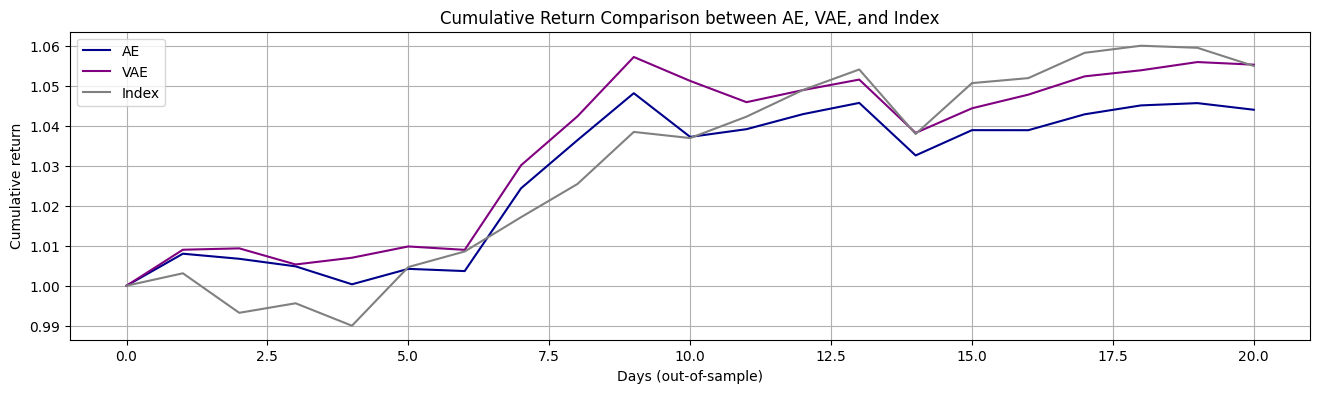

In [11]:
#Calculo y comparación de los retornos acumulados
ae_stock = ae_stock_weights_first_window
vae_stock = vae_stock_weights_first_window
ae_assets_select = ae_selected_stocks_first_window.to_list()
vae_assets_select = ae_selected_stocks_first_window.to_list()
ae_returns_select = stock_test[ae_assets_select]
vae_returns_select = stock_test[vae_assets_select]
ae_returns_select1 = ae_returns_select
vae_returns_select1 = vae_returns_select

# Retornos historicos para los portafolios Sparse construidos a partir de AE y VAE
ret_port_ae = ae_returns_select1.to_numpy() @ ae_stock
ret_port_vae = vae_returns_select1.to_numpy() @ vae_stock
ret_ndx1 = index_test
ret_ndx = ret_ndx1.values

time = len(ret_port_ae)
cumret_ae = np.zeros((time + 1))
cumret_ae[0] = 1
for i in range(1, len(cumret_ae)):
    cumret_ae[i] = cumret_ae[i - 1] * np.exp(ret_port_ae[i - 1])

cumret_vae = np.zeros((time + 1))
cumret_vae[0] = 1
for i in range(1, len(cumret_vae)):
    cumret_vae[i] = cumret_vae[i - 1] * np.exp(ret_port_vae[i - 1])

cumret_ndx = np.zeros((time + 1))
cumret_ndx[0] = 1
for i in range(1, len(cumret_ndx)):
    cumret_ndx[i] = cumret_ndx[i - 1] * np.exp(ret_ndx[i - 1])

#Grafica de los retornos acumulados del indice y de los portafolios AE y VAE
plt.figure(figsize=(16, 4))
plt.plot(cumret_ae, label='AE', color='darkblue')
plt.plot(cumret_vae, label='VAE', color='purple')
plt.plot(cumret_ndx, label='Index', color='gray')
plt.xlabel('Days (out-of-sample)')
plt.ylabel('Cumulative return')
plt.title('Cumulative Return Comparison between AE, VAE, and Index')
plt.legend()
plt.grid(True)
plt.savefig('E1: Cumulative Return Comparison between AE, VAE, and Index.png')
plt.show()

##**Experimento 2**: En este caso, se explorará si la incorporación de dropout ayuda a mejorar el overfitting que se evidenció en los resultados del experimento 1, tanto para el AE como para el VAE. A continuación, se resaltan las características de las dos arquitecturas que se implementarán:

**AE Arquitecture**

*Encoder*

+   Input Layer: 86 neurons (number of available assets).
+   First Hidden Layer: 43 neurons, ReLU activation. Dropout rate of 0.2.
+   Output Layer: 43 neurons (latent space dimension).

*Decoder*

+   Input Layer: 43 neurons (latent space dimension).
+   First Hidden Layer: 43 neurons, ReLU activation. Dropout rate of 0.2.
+   Output Layer: 86 neurons, ReLU activation.

*Training Parameters*

+   Optimizer: Adam
+   Learning Rate: 0.001
+   Loss Function: MSE (Mean Squared Error)
+   Epochs: 30
+   Batch Size: 10


**VAE Arquitecture**

*Encoder*

+   Input Layer: 86 neurons (number of available assets)
+   First Hidden Layer: 43 neurons, ReLU activation. Dropout rate of 0.2.
+   Output Layer: z\_mean and z\_log\_var, each with 2 neuron (latent space dimension).

*Sampling Layer*

+   Lambda function for reparameterization to obtain $z$ from z\_mean and z\_log\_var

*Decoder*

+   Input Layer: 2 neurons (latent space dimension)
+   First Hidden Layer: 43 neurons, ReLU activation. Dropout rate of 0.2.
+   Output Layer: 86 neurons, ReLU activation.

*Training Parameters*

+   Optimizer: Adam
+   Learning Rate: 0.001
+   Loss Function: MSE for reconstruction loss + KL Divergence loss
+   Epochs: 30
+   Batch Size: 10

In [13]:
# Parámetros
encoding_dim = 43
latent_dim = 2
num_stock = 43  # Número de acciones seleccionadas
validation_months = range(1, 13)

# Almacenar los rendimientos acumulados y tracking errors de AE y VAE
ae_cumulative_returns = []
ae_tracking_errors = []
vae_cumulative_returns = []
vae_tracking_errors = []

# Almacenar las pérdidas de entrenamiento y validación para AE y VAE
ae_train_loss = []
ae_val_loss = []
vae_train_loss = []
vae_val_loss = []

# Almacenar los activos seleccionados y sus participaciones para la primera ventana de validación
ae_selected_stocks_first_window = None
ae_stock_weights_first_window = None
vae_selected_stocks_first_window = None
vae_stock_weights_first_window = None

#Se establecerá la cantidad de tiempo de ejecución
import time
inicio = time.time()

# Iterar sobre cada mes móvil en el año 2023
for month in validation_months:
    # Definir el rango de fechas para el mes actual
    valid_month_start = f'2023-{month:02d}-01'
    valid_month_end = pd.date_range(valid_month_start, periods=1, freq='M')[0] + pd.offsets.MonthEnd(0)
    valid_month_end = valid_month_end.strftime('%Y-%m-%d')

    # Definir el rango de fechas para el período de entrenamiento
    train_end = pd.to_datetime(valid_month_start) - pd.Timedelta(days=1)
    train_start = train_end - pd.DateOffset(years=3)

    stock_train = stock_returns.loc[train_start:train_end].dropna(axis=1, how='any').astype('float32')
    stock_test = stock_returns.loc[valid_month_start:valid_month_end].dropna(axis=1, how='any').astype('float32')

    index_train = index_returns.loc[train_start:train_end].astype('float32')
    index_test = index_returns.loc[valid_month_start:valid_month_end].astype('float32')

    num_stocks_available = stock_train.shape[1]

    # Autoencoder con Dropout
    input_img = Input(shape=(num_stocks_available,))
    encoded = Dense(43, activation='relu')(input_img)
    encoded = Dropout(0.2)(encoded)
    decoded = Dense(num_stocks_available, activation='relu')(encoded)
    decoded = Dropout(0.2)(decoded)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Entrenamiento del autoencoder
    ae_history = autoencoder.fit(stock_train, stock_train, validation_data=(stock_test, stock_test),
                                 shuffle=False, epochs=30, batch_size=10, verbose=0)

    ae_train_loss.append(ae_history.history['loss'])
    ae_val_loss.append(ae_history.history['val_loss'])

    # Selección de activos para AE
    ae_reconstruct = autoencoder.predict(stock_train)
    ae_selected_indices = select_top_n_stocks_by_reconstruction_error(stock_train.values, ae_reconstruct, num_stock)
    ae_selected_stocks = stock_train.columns[ae_selected_indices]

    if ae_selected_stocks_first_window is None:
        ae_selected_stocks_first_window = ae_selected_stocks
        # Calcular las participaciones porcentuales
        ae_stock_weights_first_window = np.mean(stock_train[ae_selected_stocks], axis=0) / np.mean(stock_train[ae_selected_stocks], axis=0).sum()

    # Rendimientos acumulados y tracking error para AE
    ae_reconstruct_test = autoencoder.predict(stock_test)
    ae_predicted_returns = np.dot(stock_test[ae_selected_stocks], ae_stock_weights_first_window)
    ae_cumulative_returns.append(np.cumprod(1 + ae_predicted_returns) - 1)
    ae_tracking_errors.append(tracking_error(index_test.values.flatten(), ae_predicted_returns))

    # Variational Autoencoder con Dropout
    def build_vae(input_shape, latent_dim):
        encoder = build_encoder(input_shape, latent_dim)
        decoder = build_decoder(latent_dim, input_shape[0])
        inputs = Input(shape=input_shape)
        z_mean, z_log_var, z = encoder(inputs)
        outputs = decoder(z)

        vae = Model(inputs, outputs)

        reconstruction_loss = K.sum(K.square(inputs - outputs), axis=-1)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        vae.add_loss(vae_loss)

        vae.compile(optimizer=Adam(learning_rate=0.001))

        return vae, encoder

    def build_encoder(input_shape, latent_dim):
        inputs = Input(shape=input_shape)
        x = Dense(43, activation='relu')(inputs)
        x = Dropout(0.2)(x)
        z_mean = Dense(latent_dim)(x)
        z_log_var = Dense(latent_dim)(x)
        z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
        return Model(inputs, [z_mean, z_log_var, z])

    def build_decoder(latent_dim, original_dim):
        latent_inputs = Input(shape=(latent_dim,))
        x = Dense(43, activation='relu')(latent_inputs)
        x = Dropout(0.2)(x)
        outputs = Dense(original_dim, activation='relu')(x)
        return Model(latent_inputs, outputs)

    # Construir y entrenar el VAE
    latent_dim = 2
    vae, encoder = build_vae((num_stocks_available,), latent_dim)
    vae_history = vae.fit(stock_train, epochs=30, batch_size=10, validation_data=(stock_test, None), shuffle=False, verbose=0)

    vae_train_loss.append(vae_history.history['loss'])
    vae_val_loss.append(vae_history.history['val_loss'])

    # Selección de activos para VAE
    vae_reconstruct = vae.predict(stock_train)
    vae_selected_indices = select_top_n_stocks_by_reconstruction_error(stock_train.values, vae_reconstruct, num_stock)
    vae_selected_stocks = stock_train.columns[vae_selected_indices]

    if vae_selected_stocks_first_window is None:
        vae_selected_stocks_first_window = vae_selected_stocks
        # Calcular las participaciones porcentuales
        vae_stock_weights_first_window = np.mean(stock_train[vae_selected_stocks], axis=0) / np.mean(stock_train[vae_selected_stocks], axis=0).sum()

    # Rendimientos acumulados y tracking error para VAE
    vae_reconstruct_test = vae.predict(stock_test)
    vae_predicted_returns = np.dot(stock_test[vae_selected_stocks], vae_stock_weights_first_window)
    vae_cumulative_returns.append(np.cumprod(1 + vae_predicted_returns) - 1)
    vae_tracking_errors.append(tracking_error(index_test.values.flatten(), vae_predicted_returns))

1/1 [==============================] - 0s 20ms/step


In [14]:
fin = time.time()
print('Tiempo (segundos) de ejecución de los modelos:',fin-inicio)

132.56893253326416


##Visualizaciones de los resultados

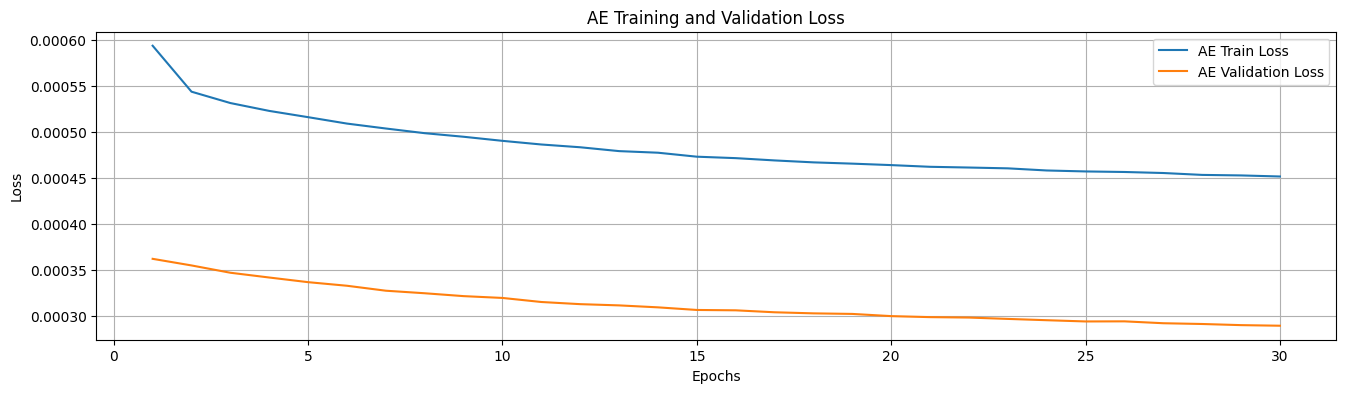

In [15]:
# Graficar las pérdidas de entrenamiento y validación para AE y VAE
epochs = range(1, 31)

plt.figure(figsize=(16, 4))
plt.plot(epochs, np.mean(ae_train_loss, axis=0), label='AE Train Loss')
plt.plot(epochs, np.mean(ae_val_loss, axis=0), label='AE Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('AE Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('E2: AE Training and Validation Loss.png')
plt.show()

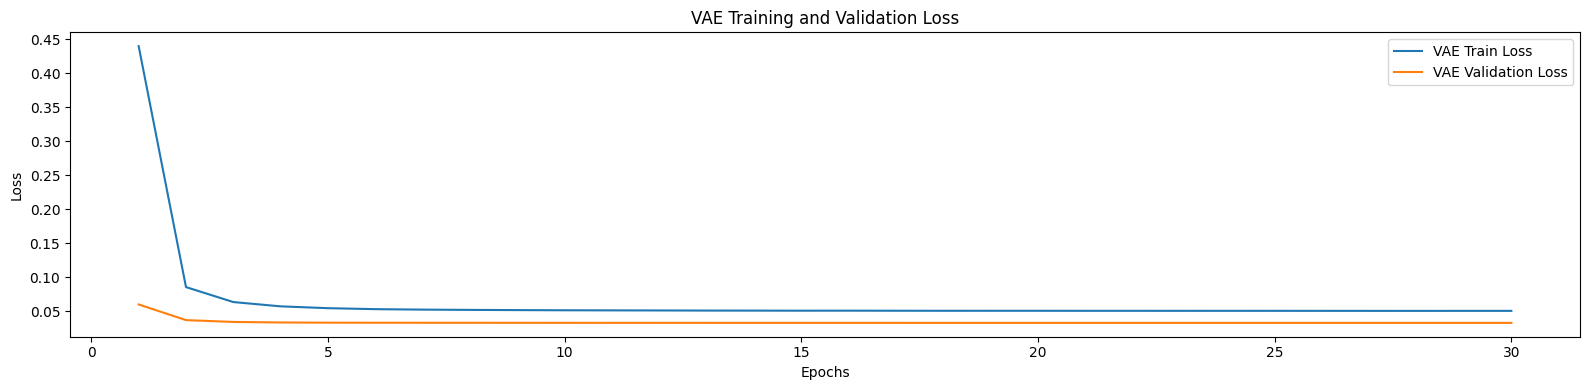

In [16]:
#Grafica de Loss para AE y VAE
plt.figure(figsize=(16,4))
plt.plot(epochs, np.mean(vae_train_loss, axis=0), label='VAE Train Loss')
plt.plot(epochs, np.mean(vae_val_loss, axis=0), label='VAE Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VAE Training and Validation Loss')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig('E2: VAE Training and Validation Loss.png')
plt.show()

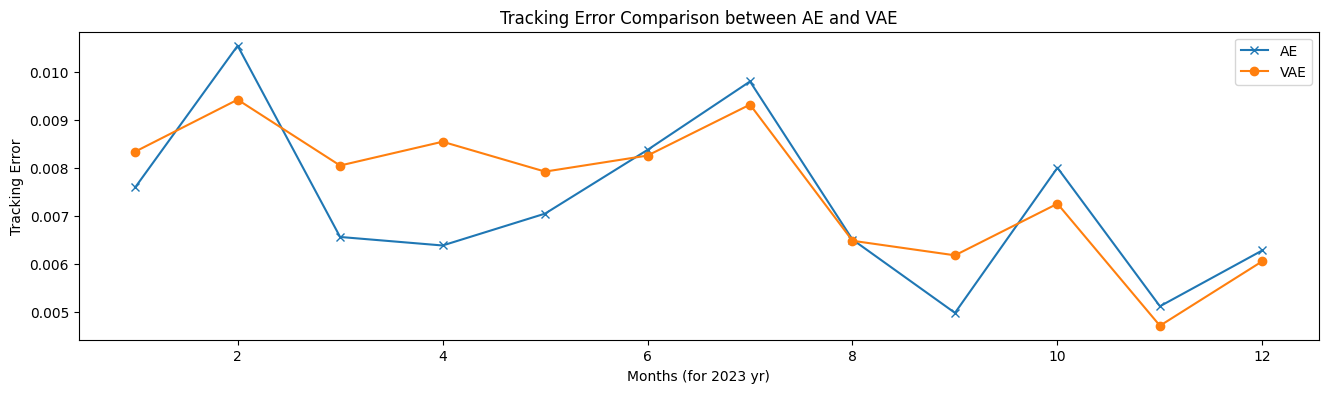

In [17]:
# Graficar los rendimientos acumulados y tracking errors para AE y VAE
plt.figure(figsize=(16,4))
plt.plot(validation_months, ae_tracking_errors, label='AE', marker='x')
plt.plot(validation_months, vae_tracking_errors, label='VAE', marker='o')
plt.xlabel('Months (for 2023 yr)')
plt.ylabel('Tracking Error')
plt.title('Tracking Error Comparison between AE and VAE')
plt.legend()
plt.grid(False)
plt.savefig('E2: Tracking Error Comparison between AE and VAE.png')
plt.show()

Tracking Error mean_AE: 0.0072644358
Tracking Error mean_VAE: 0.007542465


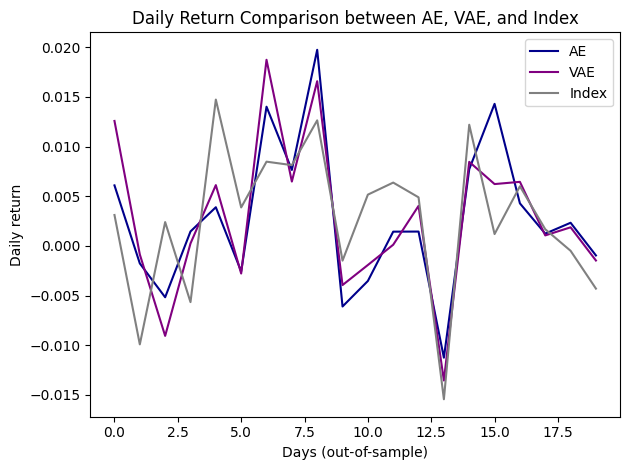

In [18]:
# Promedio de Tracking Error por modelo
AE_mean_TE = np.mean(ae_tracking_errors)
VAE_mean_TE = np.mean(vae_tracking_errors)
print('Tracking Error mean_AE:', AE_mean_TE)
print('Tracking Error mean_VAE:', VAE_mean_TE)

# Grafica de comparación de retorno diario entre el índice y los portafolios AE y VAE
plt.plot(figsize=(16,4))
plt.plot(ae_predicted_returns, label='AE', color='darkblue')
plt.plot(vae_predicted_returns, label='VAE', color='purple')
plt.plot(index_test.values.flatten(), label='Index', color='gray')
plt.xlabel('Days (out-of-sample)')
plt.ylabel('Daily return')
plt.title('Daily Return Comparison between AE, VAE, and Index')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig('E2: Daily Return Comparison between AE, VAE, and Index.png')
plt.show()

<ipython-input-19-42529dcbb514>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cumret_ndx[i] = cumret_ndx[i - 1] * np.exp(ret_ndx[i - 1])


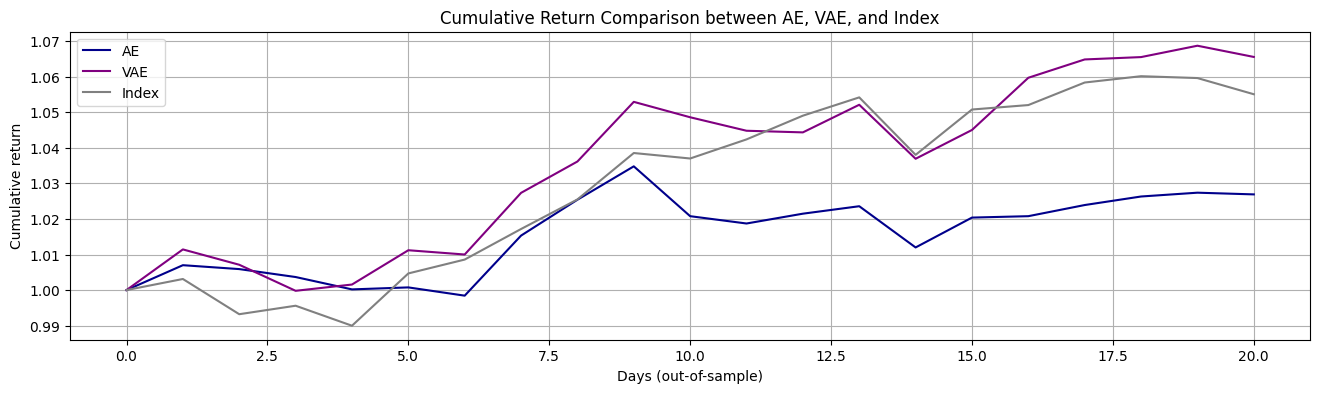

In [19]:
#Calculo y comparación de los retornos acumulados
ae_stock = ae_stock_weights_first_window
vae_stock = vae_stock_weights_first_window
ae_assets_select = ae_selected_stocks_first_window.to_list()
vae_assets_select = ae_selected_stocks_first_window.to_list()
ae_returns_select = stock_test[ae_assets_select]
vae_returns_select = stock_test[vae_assets_select]
ae_returns_select1 = ae_returns_select
vae_returns_select1 = vae_returns_select

# Retornos para los portafolios Sparse construidos a partir de AE y VAE
ret_port_ae = ae_returns_select1.to_numpy() @ ae_stock
ret_port_vae = vae_returns_select1.to_numpy() @ vae_stock
ret_ndx1 = index_test
ret_ndx = ret_ndx1.values

time = len(ret_port_ae)
cumret_ae = np.zeros((time + 1))
cumret_ae[0] = 1
for i in range(1, len(cumret_ae)):
    cumret_ae[i] = cumret_ae[i - 1] * np.exp(ret_port_ae[i - 1])

cumret_vae = np.zeros((time + 1))
cumret_vae[0] = 1
for i in range(1, len(cumret_vae)):
    cumret_vae[i] = cumret_vae[i - 1] * np.exp(ret_port_vae[i - 1])

cumret_ndx = np.zeros((time + 1))
cumret_ndx[0] = 1
for i in range(1, len(cumret_ndx)):
    cumret_ndx[i] = cumret_ndx[i - 1] * np.exp(ret_ndx[i - 1])

#Grafica de los retornos acumulados del indice y de los portafolios AE y VAE
plt.figure(figsize=(16, 4))
plt.plot(cumret_ae, label='AE', color='darkblue')
plt.plot(cumret_vae, label='VAE', color='purple')
plt.plot(cumret_ndx, label='Index', color='gray')
plt.xlabel('Days (out-of-sample)')
plt.ylabel('Cumulative return')
plt.title('Cumulative Return Comparison between AE, VAE, and Index')
plt.legend()
plt.grid(True)
plt.savefig('E2: Cumulative Return Comparison between AE, VAE, and Index.png')
plt.show()

## **Experimento 3**: En este caso, se explorará si la incorporación de regularización L2 ayuda a mejorar el overfitting que se evidenció en los resultados del experimento 1, tanto para el AE como para el VAE. A continuación, se resaltan las características de las dos arquitecturas que se implementarán:

**AE Arquitecture**

*Encoder*

*   Input Layer: 86 neurons (number of available assets).
*   First Hidden Layer: 43 neurons, ReLU activation, L2 regularization (penalty factor 0.01).
+   Output Layer: 43 neurons (latent space dimension).

Decoder

+   Input Layer: 43 neurons (latent space dimension).
+   First Hidden Layer: 43 neurons, ReLU activation, L2 regularization (penalty factor 0.01).
+   Output Layer: 86 neurons, ReLU activation.

*Training Parameters*

+    Optimizer: Adam
+    Learning Rate: 0.001
+    Loss Function: MSE (Mean Squared Error)
+    Epochs: 30
+    Batch Size: 10


**VAE Arquitecture**

*Encoder*

+    Input Layer: 86 neurons (number of available assets)
+    First Hidden Layer: 43 neurons, ReLU activation, L2 regularization (penalty factor 0.01).
+    Output Layer: z\_mean and z\_log\_var, each with 2 neurons (latent dimension), L2 regularization (penalty factor 0.01)
    

*Sampling Layer*

+    Lambda function for reparameterization to obtain $z$ from z\_mean and z\_log\_var

*Decoder*

+    Input Layer: 2 neurons (latent space dimension)
+    First Hidden Layer: 43 neurons, ReLU activation, L2 regularization (penalty factor 0.01).
+    Output Layer: 86 neurons, ReLU activation, L2 regularization (penalty factor 0.01).

*Training Parameters*

+    Optimizer: Adam
+    Learning Rate: 0.001
+    Loss Function: MSE for reconstruction loss + KL Divergence loss
+    Epochs: 30
+    Batch Size: 10

In [21]:
# Parámetros
encoding_dim = 43
latent_dim = 2
num_stock = 43  # Número de acciones seleccionadas
validation_months = range(1, 13)

# Almacenar los rendimientos acumulados y tracking errors de AE y VAE
ae_cumulative_returns = []
ae_tracking_errors = []
vae_cumulative_returns = []
vae_tracking_errors = []

# Almacenar las pérdidas de entrenamiento y validación para AE y VAE
ae_train_loss = []
ae_val_loss = []
vae_train_loss = []
vae_val_loss = []

# Almacenar los activos seleccionados y sus participaciones para la primera ventana de validación
ae_selected_stocks_first_window = None
ae_stock_weights_first_window = None
vae_selected_stocks_first_window = None
vae_stock_weights_first_window = None

#Se establecerá la cantidad de tiempo de ejecución
import time
inicio = time.time()

# Iterar sobre cada mes móvil en el año 2023
for month in validation_months:
    # Definir el rango de fechas para el mes actual
    valid_month_start = f'2023-{month:02d}-01'
    valid_month_end = pd.date_range(valid_month_start, periods=1, freq='M')[0] + pd.offsets.MonthEnd(0)
    valid_month_end = valid_month_end.strftime('%Y-%m-%d')

    # Definir el rango de fechas para el período de entrenamiento
    train_end = pd.to_datetime(valid_month_start) - pd.Timedelta(days=1)
    train_start = train_end - pd.DateOffset(years=3)

    stock_train = stock_returns.loc[train_start:train_end].dropna(axis=1, how='any').astype('float32')
    stock_test = stock_returns.loc[valid_month_start:valid_month_end].dropna(axis=1, how='any').astype('float32')

    index_train = index_returns.loc[train_start:train_end].astype('float32')
    index_test = index_returns.loc[valid_month_start:valid_month_end].astype('float32')

    num_stocks_available = stock_train.shape[1]

    # Autoencoder
    input_img = Input(shape=(num_stocks_available,))
    encoded = Dense(43, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(num_stocks_available, activation='relu', kernel_regularizer=regularizers.l2(0.01))(encoded)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Entrenamiento del autoencoder
    ae_history = autoencoder.fit(stock_train, stock_train, validation_data=(stock_test, stock_test),
                             shuffle=False, epochs=30, batch_size=10, verbose=0)

    ae_train_loss.append(ae_history.history['loss'])
    ae_val_loss.append(ae_history.history['val_loss'])

    # Selección de activos para AE
    ae_reconstruct = autoencoder.predict(stock_train)
    ae_selected_indices = select_top_n_stocks_by_reconstruction_error(stock_train.values, ae_reconstruct, num_stock)
    ae_selected_stocks = stock_train.columns[ae_selected_indices]

    if ae_selected_stocks_first_window is None:
        ae_selected_stocks_first_window = ae_selected_stocks
        # Calcular las participaciones porcentuales
        ae_stock_weights_first_window = np.mean(stock_train[ae_selected_stocks], axis=0) / np.mean(stock_train[ae_selected_stocks], axis=0).sum()

    # Rendimientos acumulados y tracking error para AE
    ae_reconstruct_test = autoencoder.predict(stock_test)
    ae_predicted_returns = np.dot(stock_test[ae_selected_stocks], ae_stock_weights_first_window)
    ae_cumulative_returns.append(np.cumprod(1 + ae_predicted_returns) - 1)
    ae_tracking_errors.append(tracking_error(index_test.values.flatten(), ae_predicted_returns))

    #Variational Autoencoder

    def build_encoder(input_shape, latent_dim):
        inputs = Input(shape=input_shape)
        x = Dense(43, activation='relu', kernel_regularizer=regularizers.l2(0.01))(inputs)
        z_mean = Dense(latent_dim, kernel_regularizer=regularizers.l2(0.01))(x)
        z_log_var = Dense(latent_dim, kernel_regularizer=regularizers.l2(0.01))(x)
        z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
        return Model(inputs, [z_mean, z_log_var, z])

    def build_decoder(latent_dim, original_dim):
        latent_inputs = Input(shape=(latent_dim,))
        x = Dense(43, activation='relu', kernel_regularizer=regularizers.l2(0.01))(latent_inputs)
        outputs = Dense(original_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        return Model(latent_inputs, outputs)

    def build_vae(input_shape, latent_dim):
        encoder = build_encoder(input_shape, latent_dim)
        decoder = build_decoder(latent_dim, input_shape[0])
        inputs = Input(shape=input_shape)
        z_mean, z_log_var, z = encoder(inputs)
        outputs = decoder(z)

        vae = Model(inputs, outputs)

        reconstruction_loss = K.sum(K.square(inputs - outputs), axis=-1)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        vae.add_loss(vae_loss)

        vae.compile(optimizer=Adam(learning_rate=0.001))
        return vae, encoder

    # Construir y entrenar el VAE
    latent_dim = 2
    vae, encoder = build_vae((num_stocks_available,), latent_dim)
    vae_history = vae.fit(stock_train, epochs=30, batch_size=10, validation_data=(stock_test, None), shuffle=False, verbose=0)

    vae_train_loss.append(vae_history.history['loss'])
    vae_val_loss.append(vae_history.history['val_loss'])

    # Selección de activos para VAE
    vae_reconstruct = vae.predict(stock_train)
    vae_selected_indices = select_top_n_stocks_by_reconstruction_error(stock_train.values, vae_reconstruct, num_stock)
    vae_selected_stocks = stock_train.columns[vae_selected_indices]

    if vae_selected_stocks_first_window is None:
        vae_selected_stocks_first_window = vae_selected_stocks
        # Calcular las participaciones porcentuales
        vae_stock_weights_first_window = np.mean(stock_train[vae_selected_stocks], axis=0) / np.mean(stock_train[vae_selected_stocks], axis=0).sum()

    # Rendimientos acumulados y tracking error para VAE
    vae_reconstruct_test = vae.predict(stock_test)
    vae_predicted_returns = np.dot(stock_test[vae_selected_stocks], vae_stock_weights_first_window)
    vae_cumulative_returns.append(np.cumprod(1 + vae_predicted_returns) - 1)
    vae_tracking_errors.append(tracking_error(index_test.values.flatten(), vae_predicted_returns))

1/1 [==============================] - 0s 18ms/step


In [22]:
fin = time.time()
print('Tiempo (segundos) de ejecución de los modelos:',fin-inicio)

134.8483064174652


##Visualizaciones de los resultados

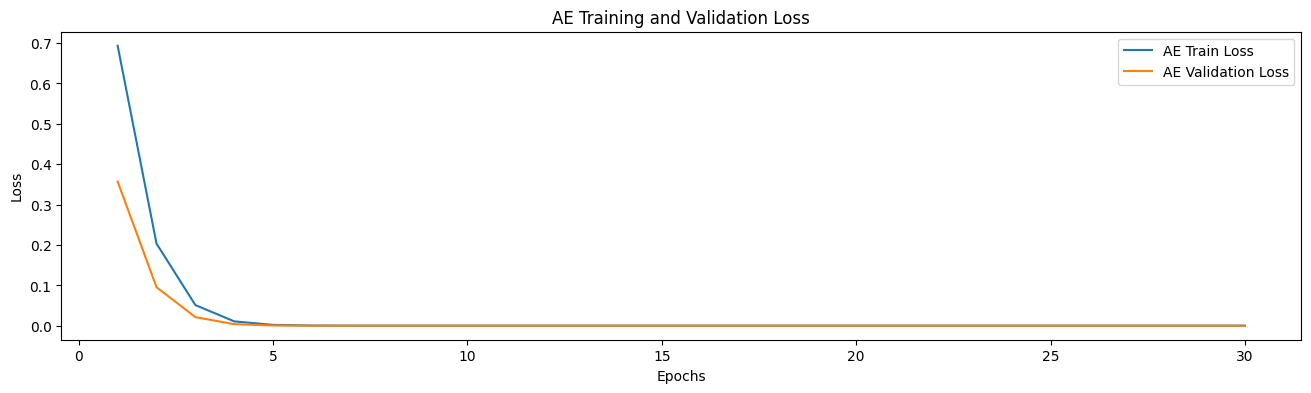

In [23]:
# Graficar las pérdidas de entrenamiento y validación para AE y VAE
epochs = range(1, 31)
plt.figure(figsize=(16, 4))
plt.plot(epochs, np.mean(ae_train_loss, axis=0), label='AE Train Loss')
plt.plot(epochs, np.mean(ae_val_loss, axis=0), label='AE Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('AE Training and Validation Loss')
plt.legend()
plt.savefig('E3: AE Training and Validation Loss.png')
plt.grid(False)
plt.show()

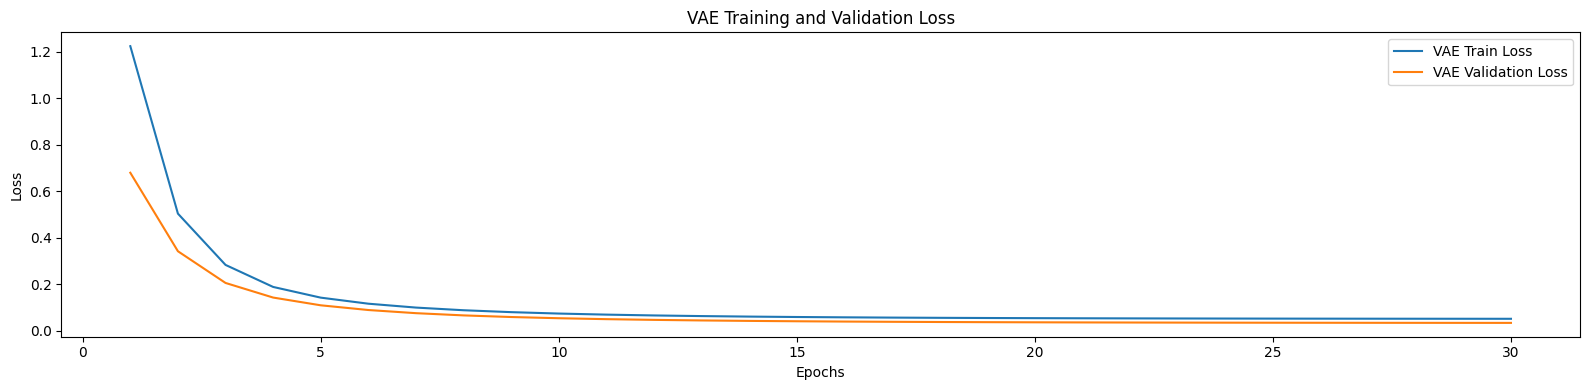

In [24]:
#Grafica de Loss para AE y VAE
plt.figure(figsize=(16,4))
plt.plot(epochs, np.mean(vae_train_loss, axis=0), label='VAE Train Loss')
plt.plot(epochs, np.mean(vae_val_loss, axis=0), label='VAE Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VAE Training and Validation Loss')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig('E3: VAE Training and Validation Loss.png')
plt.show()

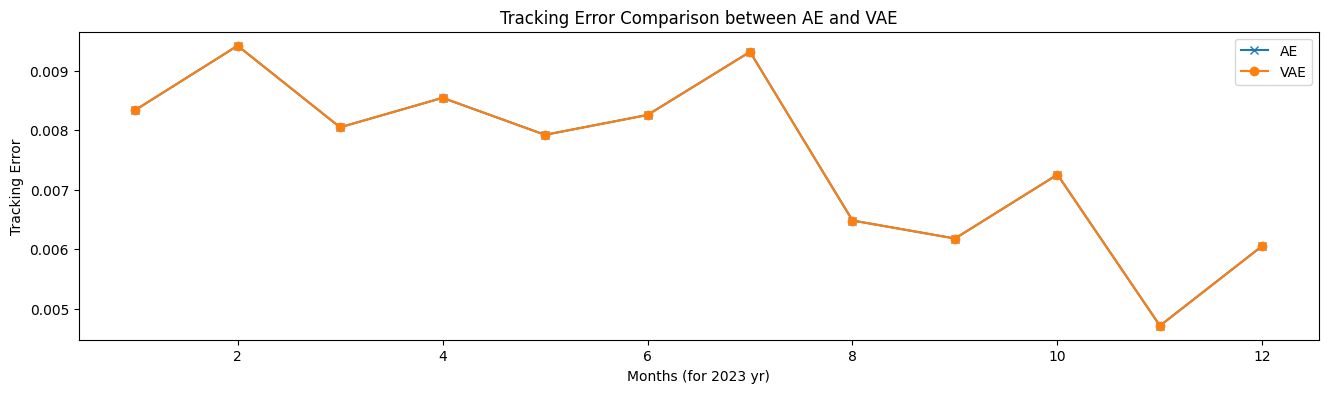

In [25]:
# Graficar los rendimientos acumulados y tracking errors para AE y VAE
plt.figure(figsize=(16,4))
plt.plot(validation_months, ae_tracking_errors, label='AE', marker='x')
plt.plot(validation_months, vae_tracking_errors, label='VAE', marker='o')
plt.xlabel('Months (for 2023 yr)')
plt.ylabel('Tracking Error')
plt.title('Tracking Error Comparison between AE and VAE')
plt.legend()
plt.grid(False)
plt.savefig('E3: Tracking Error Comparison between AE and VAE.png')
plt.show()

Tracking Error mean_AE: 0.007542465
Tracking Error mean_VAE: 0.007542465


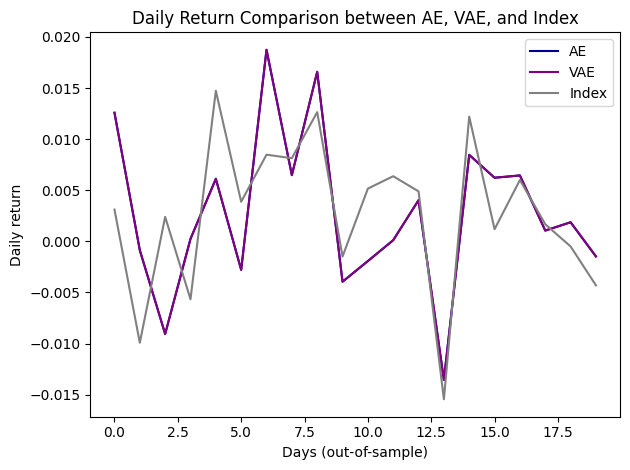

In [26]:
# Promedio de Tracking Error por modelo
AE_mean_TE = np.mean(ae_tracking_errors)
VAE_mean_TE = np.mean(vae_tracking_errors)
print('Tracking Error mean_AE:', AE_mean_TE)
print('Tracking Error mean_VAE:', VAE_mean_TE)

# Grafica de comparación de retorno diario entre el índice y los portafolios AE y VAE
plt.plot(figsize=(16,4))
plt.plot(ae_predicted_returns, label='AE', color='darkblue')
plt.plot(vae_predicted_returns, label='VAE', color='purple')
plt.plot(index_test.values.flatten(), label='Index', color='gray')
plt.xlabel('Days (out-of-sample)')
plt.ylabel('Daily return')
plt.title('Daily Return Comparison between AE, VAE, and Index')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig('E3: Daily Return Comparison between AE, VAE, and Index.png')
plt.show()

<ipython-input-27-9c187663f750>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cumret_ndx[i] = cumret_ndx[i - 1] * np.exp(ret_ndx[i - 1])


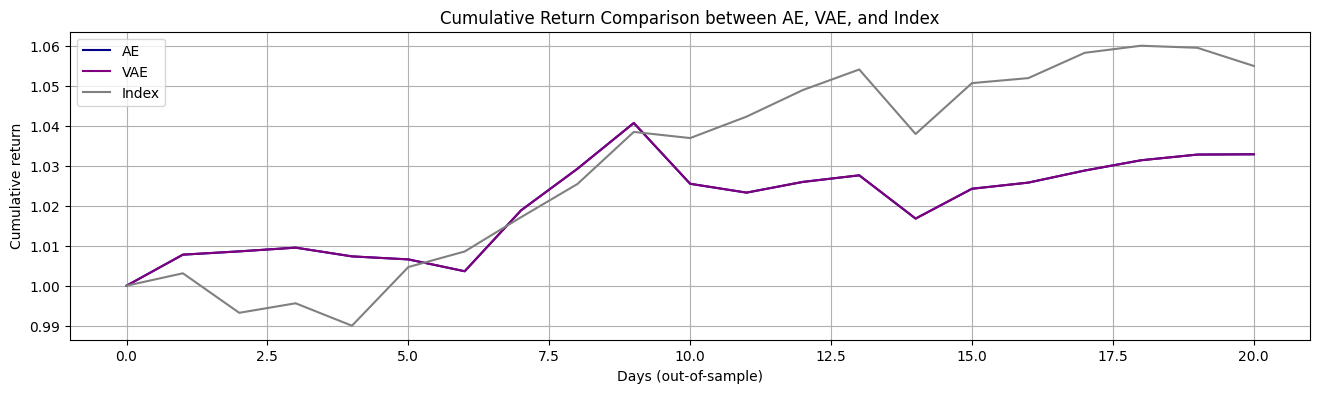

In [27]:
#Calculo y comparación de los retornos acumulados
ae_stock = ae_stock_weights_first_window
vae_stock = vae_stock_weights_first_window
ae_assets_select = ae_selected_stocks_first_window.to_list()
vae_assets_select = ae_selected_stocks_first_window.to_list()
ae_returns_select = stock_test[ae_assets_select]
vae_returns_select = stock_test[vae_assets_select]
ae_returns_select1 = ae_returns_select
vae_returns_select1 = vae_returns_select

# Retornos para los portafolios Sparse construidos a partir de AE y VAE
ret_port_ae = ae_returns_select1.to_numpy() @ ae_stock
ret_port_vae = vae_returns_select1.to_numpy() @ vae_stock
ret_ndx1 = index_test
ret_ndx = ret_ndx1.values

time = len(ret_port_ae)
cumret_ae = np.zeros((time + 1))
cumret_ae[0] = 1
for i in range(1, len(cumret_ae)):
    cumret_ae[i] = cumret_ae[i - 1] * np.exp(ret_port_ae[i - 1])

cumret_vae = np.zeros((time + 1))
cumret_vae[0] = 1
for i in range(1, len(cumret_vae)):
    cumret_vae[i] = cumret_vae[i - 1] * np.exp(ret_port_vae[i - 1])

cumret_ndx = np.zeros((time + 1))
cumret_ndx[0] = 1
for i in range(1, len(cumret_ndx)):
    cumret_ndx[i] = cumret_ndx[i - 1] * np.exp(ret_ndx[i - 1])

#Grafica de los retornos acumulados del indice y de los portafolios AE y VAE
plt.figure(figsize=(16, 4))
plt.plot(cumret_ae, label='AE', color='darkblue')
plt.plot(cumret_vae, label='VAE', color='purple')
plt.plot(cumret_ndx, label='Index', color='gray')
plt.xlabel('Days (out-of-sample)')
plt.ylabel('Cumulative return')
plt.title('Cumulative Return Comparison between AE, VAE, and Index')
plt.legend()
plt.grid(True)
plt.savefig('E3: Cumulative Return Comparison between AE, VAE, and Index.png')
plt.show()